This notebook uses [PyTorch](https://pytorch.org/), which is a library that can automatically differentiate functions and is commonly used to implement neural networks. Because of its capability to automatically differentiate functions, the formula for the gradient does not need to be manually derived -- this comes especially handy when working with neural networks, whose gradient formula can be quite complicated, especially for complex architectures. 

We recommend going over the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) and then the starter code below. For any new functions that you come across, you can look up the documentation [here](https://pytorch.org/docs/stable/index.html). 

We recommend running this notebook on Google Colab to avoid having to install PyTorch and to take advantage of GPUs, which make training faster.

## Load packages

In [1]:
# load packages
# make sure to install the pacakge "tqdm" for the progress bar when training.
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import ndimage
import random
path_prefix = ""

If running on Google Colab, you need to upload the file `autoencoder_starter.py`. To do so, you need to click on the folder icon on the left side of the page, which brings up a panel that would allow you to upload files. Note however uploading the file this way has a downside in that if your Python runtime times out or is otherwise restarted, the file will be erased and you will need to re-upload. 

If you would like to avoid this, you can create a directory named `CMPT_726Fall2021_A3` in your Google Drive and upload `autoencoder_starter.py` to that directory. Then execute the following block of code to mount your Google Drive. 

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainTransform  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.FashionMNIST(root='{}/./data'.format(path_prefix),  train=True,download=True, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /./data/FashionMNIST/raw



In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
path_prefix = "/content/gdrive/MyDrive/CMPT_726Fall2021_A4"

import sys
sys.path.insert(1, path_prefix)

sys.path

Mounted at /content/gdrive


['',
 '/content/gdrive/MyDrive/CMPT_726Fall2021_A4',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

## Define your architecture here.

The `Autoencoder` class has several important functions unimplemented. You are required to implement the two sub-classes of `Encoder` and `Decoder`, i.e, the architecture and forward function of the encoder and decoder.


In [7]:
class Autoencoder(nn.Module):
    def __init__(self,dim_latent_representation=2):
        super(Autoencoder,self).__init__()
        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                self.encoder = nn.Sequential(
                    nn.Linear(28*28*1, output_size),
                    nn.Tanh())

            def forward(self, x):
                x = self.encoder(x)
                return x

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                self.decoder = nn.Sequential(
                    nn.Linear(input_size, 28*28*1),
                    nn.Sigmoid())
                    
            def forward(self, z):
                z = self.decoder(z)
                return z

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the DAE model
    def add_noise(self, x, noise_type):
      torch.manual_seed(2021)
      if noise_type=="Dropout":
        drop_x = torch.nn.Dropout(p=0.5, inplace=False)
        x = drop_x(x)
        return x
      elif noise_type=="Gaussian":
        x = x + 0.3 * torch.rand(x.shape)
        x = np.clip(x, 0., 1.)
        return x

      ###Readme: 
      """ To run CASE 1: Without Dropout and Gaussian: Comment both add_noise lines in foward function
                 CASE 2: With Dropout : Comment add_noise with noise_type = Gaussian
                 CASE 3: With Gaussian : Comment add_noise with noise_type = Dropout
      """    
    def forward(self,x):
      # x = self.add_noise(x, noise_type='Dropout') #uncomment and run for case 2 
      # x = self.add_noise(x, noise_type='Gaussian') #uncomment and run for case 3 
      x = self.encoder(x)
      x = self.decoder(x)
      return x

## Training the Model

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.

In [8]:
from autoencoder_starter import Autoencoder_Trainer

LEARNING_RATE = 0.001
EPOCH_NUMBER= 20 # the number of epochs and learning rate can be tuned.

autoencoder = Autoencoder(dim_latent_representation=30)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder,learning_rate=LEARNING_RATE)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
        print("Manual Interruption")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1875/1875 [00:17<00:00, 106.38it/s]

====> Epoch: 1 Average loss: 0.7319



100%|██████████| 313/313 [00:02<00:00, 124.66it/s]

====> Val set loss (reconstruction error) : 0.6474



100%|██████████| 1875/1875 [00:17<00:00, 107.16it/s]

====> Epoch: 2 Average loss: 0.6343



100%|██████████| 313/313 [00:02<00:00, 123.53it/s]

====> Val set loss (reconstruction error) : 0.6233



100%|██████████| 1875/1875 [00:17<00:00, 109.13it/s]

====> Epoch: 3 Average loss: 0.6199



100%|██████████| 313/313 [00:02<00:00, 121.92it/s]

====> Val set loss (reconstruction error) : 0.6152



100%|██████████| 1875/1875 [00:17<00:00, 108.72it/s]

====> Epoch: 4 Average loss: 0.6145



100%|██████████| 313/313 [00:02<00:00, 124.38it/s]

====> Val set loss (reconstruction error) : 0.6118



100%|██████████| 1875/1875 [00:17<00:00, 108.83it/s]

====> Epoch: 5 Average loss: 0.6121



100%|██████████| 313/313 [00:02<00:00, 132.37it/s]

====> Val set loss (reconstruction error) : 0.6101



100%|██████████| 1875/1875 [00:16<00:00, 112.84it/s]

====> Epoch: 6 Average loss: 0.6108



100%|██████████| 313/313 [00:02<00:00, 124.26it/s]

====> Val set loss (reconstruction error) : 0.6095



100%|██████████| 1875/1875 [00:17<00:00, 105.45it/s]

====> Epoch: 7 Average loss: 0.6100



100%|██████████| 313/313 [00:02<00:00, 124.99it/s]

====> Val set loss (reconstruction error) : 0.6087



100%|██████████| 1875/1875 [00:18<00:00, 104.11it/s]

====> Epoch: 8 Average loss: 0.6095



100%|██████████| 313/313 [00:02<00:00, 120.71it/s]

====> Val set loss (reconstruction error) : 0.6082



100%|██████████| 1875/1875 [00:18<00:00, 103.86it/s]

====> Epoch: 9 Average loss: 0.6091



100%|██████████| 313/313 [00:02<00:00, 122.25it/s]

====> Val set loss (reconstruction error) : 0.6081



100%|██████████| 1875/1875 [00:17<00:00, 104.39it/s]

====> Epoch: 10 Average loss: 0.6087



100%|██████████| 313/313 [00:02<00:00, 120.81it/s]

====> Val set loss (reconstruction error) : 0.6077



100%|██████████| 1875/1875 [00:17<00:00, 104.96it/s]

====> Epoch: 11 Average loss: 0.6085



100%|██████████| 313/313 [00:02<00:00, 117.07it/s]

====> Val set loss (reconstruction error) : 0.6074



100%|██████████| 1875/1875 [00:18<00:00, 101.26it/s]

====> Epoch: 12 Average loss: 0.6083



100%|██████████| 313/313 [00:02<00:00, 117.59it/s]

====> Val set loss (reconstruction error) : 0.6072



100%|██████████| 1875/1875 [00:18<00:00, 103.88it/s]

====> Epoch: 13 Average loss: 0.6081



100%|██████████| 313/313 [00:02<00:00, 123.96it/s]

====> Val set loss (reconstruction error) : 0.6071



100%|██████████| 1875/1875 [00:18<00:00, 103.72it/s]

====> Epoch: 14 Average loss: 0.6079



100%|██████████| 313/313 [00:02<00:00, 116.09it/s]

====> Val set loss (reconstruction error) : 0.6070



100%|██████████| 1875/1875 [00:18<00:00, 99.83it/s] 

====> Epoch: 15 Average loss: 0.6078



100%|██████████| 313/313 [00:02<00:00, 117.09it/s]

====> Val set loss (reconstruction error) : 0.6069



100%|██████████| 1875/1875 [00:17<00:00, 104.85it/s]

====> Epoch: 16 Average loss: 0.6077



100%|██████████| 313/313 [00:02<00:00, 121.36it/s]

====> Val set loss (reconstruction error) : 0.6068



100%|██████████| 1875/1875 [00:17<00:00, 105.17it/s]

====> Epoch: 17 Average loss: 0.6076



100%|██████████| 313/313 [00:02<00:00, 124.14it/s]

====> Val set loss (reconstruction error) : 0.6067



100%|██████████| 1875/1875 [00:17<00:00, 105.38it/s]

====> Epoch: 18 Average loss: 0.6075



100%|██████████| 313/313 [00:02<00:00, 123.48it/s]

====> Val set loss (reconstruction error) : 0.6065



100%|██████████| 1875/1875 [00:18<00:00, 103.06it/s]

====> Epoch: 19 Average loss: 0.6074



100%|██████████| 313/313 [00:02<00:00, 120.59it/s]

====> Val set loss (reconstruction error) : 0.6065



100%|██████████| 1875/1875 [00:18<00:00, 102.87it/s]

====> Epoch: 20 Average loss: 0.6073



100%|██████████| 313/313 [00:02<00:00, 124.12it/s]

====> Val set loss (reconstruction error) : 0.6063


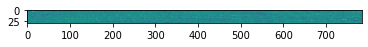

In [23]:
# Calling Plot_kernel function to get image
from autoencoder_starter import Plot_Kernel
plot_kernel_weight = Plot_Kernel(autoencoder)
plt.imshow(plot_kernel_weight.detach().numpy())

If in the above cell, you find that the download of the dataset is unsuccessful because the server is down, you can also download the data from Canvas and put the data in the same directory of this notebook and `autoencoder_starter.py`. If you are running this notebook on Google Colab, you can create a directory called `CMPT_726Fall2021_A3` in your Google Drive and put the data directory you downloaded from Canvas inside. Then if you haven't mounted your Google Drive earlier using the block of code above, mount Google Drive by executing the following block of code.

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')
path_prefix = "/content/gdrive/MyDrive/CMPT_726Fall2021_A4"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Visualizing 2D Bottleneck Feature Representations

We can visualize the 2D bottleneck representations of data points and their ground truth class labels with a scatter plot.

The `scatter_plot` function takes the following arguments:
* latent_presentations - (N, dimension_latent_representation) numpy array
* labels - (N, ) numpy array: the labels of the ground truth classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(10000, 30)
[9 2 1 ... 8 1 5]


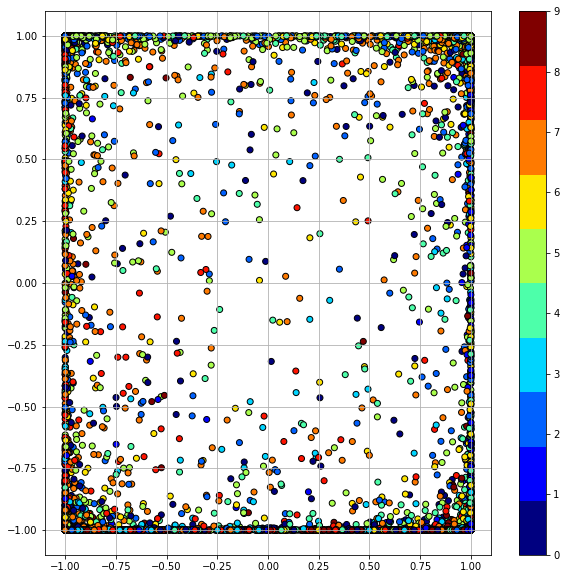

In [24]:
with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:
        x = x.reshape(-1,784)
        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)
print(z.shape)
print(label)
from autoencoder_starter import scatter_plot
scatter_plot(latent_representations = z,labels =label)

## Generating Images by Sampling Bottleneck Features

So here we can generate new images by sampling bottleneck features, and use the decoder to generate images. 

The code below provides an example of how to generate images by sampling bottleneck features. 

The `display_images_in_a_row` takes the following arguments:
* images: (N,28,28): N images of 28*28 as a numpy array
* file_path: file path name for where to store the figure
* display: display the image or not


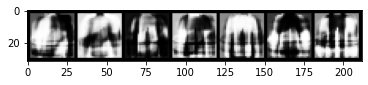

In [28]:
with torch.no_grad():
    samples = torch.randn(7, 30).to(trainer.device)
    samples = trainer.model.decoder(samples).cpu()

images = samples

from autoencoder_starter import display_images_in_a_row
display_images_in_a_row(images)

## Reconstructing Images

We can first retrieve the validation set and then pick 64 images (the first 64 images, though you can do it randomly).

We use the autoencoder to reconstruct the images and visualize them below.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Original images


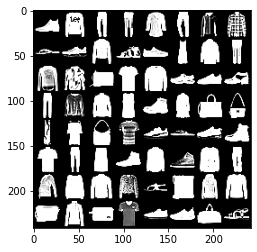

In [29]:
images = trainer.get_val_set() # get the entire validation set
total_number = 64
images = images[:total_number]

from autoencoder_starter import display_images_in_a_row
print("Original images")
display_images_in_a_row(images.cpu())

Reconstructed images


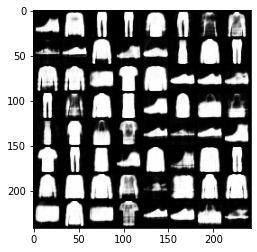

In [30]:
with torch.no_grad():
    images = images.reshape(-1,784)
    images = images.to(trainer.device)
    reconstructed = trainer.model(images).cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)